<h1>Lab | Clustering songs</h1>

Now it's time to cluster the songs of the **hot_songs** and **not_hot_songs** databases according to the song's audio features. For this purpose, you need to consider the following questions:

- Are you going to use all the audio features? If not, which ones do you think that makes more sense to be used?
- What is the optimal number of clusters (for methods that need to know this beforehand)?
- What is the best distance to use?
- What clustering method provides better results?
- Does the clustering method need a transformer?

**Considerations**

Be aware that this process is extremely time-consuming!!! (it might take several hours in your laptop). Therefore, when testing different options, save the models into your disk in order to be able to use the best model later. You don't want to retrain the best model again when you know what are the optimal parameters for each. To determine which clustering method performs best, you need to be practical and think how many clusters you might want to have alongside with a clustering metric to evaluate how good or bad the songs were clustered. If the number of clusters is small, each cluster will be too big and generic. On the other hand, if the number of clusters is too big then each cluster it will be too specific and it will be poorly populated (this it also depend on how heterogeneous is your dataset).

On the other hand, when you train your clustering model make sure to concatenate both databases together (ie: **hot_songs** and **not_hot_songs**) before. If you don't combine both datasets, the clusters obtained with the **hot_songs** will be different than the ones obtained with the **not_hot_songs** database even though they might have the same label because they will contain different songs. However, after this you will not know to which original dataframe belongs each song. To prevent this problem, you can add a new column named "dataset" with a "flag" to remind yourself in which dataset was included each song.

Finally, add new column to the full dataset **for each clustering method with the cluster membership of each song**

In [1]:
import pandas as pd
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.mixture import GaussianMixture
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sys
sys.path.insert(1, '/content/drive/MyDrive/Credentials/')
from config import *
import json

**Let's choose audio features that we will use in our models.**

In [2]:
pd.set_option('display.max_columns', None)
final_dataset = pd.read_csv('final_dataset.csv')
final_dataset.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4


In [3]:
final_dataset.columns

Index(['track_name', 'artist_name', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [4]:
data = final_dataset[['track_name', 'artist_name', 'type', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'tempo', 'time_signature']]
data.head()

,track_name,artist_name,type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,anti-hero,taylor swift,hot,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,97.008,4
1,lift me up,rihanna,hot,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,177.115,4
2,bad habit,steve lacy,hot,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,168.955,4
3,as it was,harry styles,hot,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,173.930,4
4,lavender haze,taylor swift,hot,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,96.985,4


In [5]:
numerical_df = final_dataset.select_dtypes(np.number)
X = numerical_df[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'tempo', 'time_signature']]
display(X.head())
display(X.describe())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,97.008,4
1,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,177.115,4
2,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,168.955,4
3,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,173.930,4
4,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,96.985,4


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,0.553274,0.576020,5.345935,-9.526688,0.712843,0.069094,0.329874,0.077450,0.196316,120.163958,3.896686
std,0.160590,0.237822,3.563238,4.088085,0.452494,0.074288,0.321676,0.209585,0.167393,29.525342,0.389508
min,0.099400,0.022000,0.000000,-33.424000,0.000000,0.022600,0.000001,0.000000,0.018500,38.498000,1.000000
25%,0.442000,0.391250,2.000000,-12.170000,0.000000,0.032000,0.031950,0.000000,0.094525,96.491500,4.000000
50%,0.557000,0.588000,5.000000,-8.984500,1.000000,0.040950,0.218000,0.000079,0.127000,118.033500,4.000000
75%,0.667000,0.770000,9.000000,-6.367000,1.000000,0.067975,0.614000,0.007488,0.243750,139.949500,4.000000
max,0.979000,0.998000,11.000000,-0.734000,1.000000,0.914000,0.995000,0.985000,0.991000,209.034000,5.000000


For clustering we will use K-means, Gaussian Mixtures and Agglomerative clustering. 
And then we will compare their result.


<h2>1. K-means (by Julia)</h2>

Wikipedia: "k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster."

<h3>1.1 Scaling features</h3>

In [6]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,0.553274,0.576020,5.345935,-9.526688,0.712843,0.069094,0.329874,0.077450,0.196316,120.163958,3.896686
std,0.160590,0.237822,3.563238,4.088085,0.452494,0.074288,0.321676,0.209585,0.167393,29.525342,0.389508
min,0.099400,0.022000,0.000000,-33.424000,0.000000,0.022600,0.000001,0.000000,0.018500,38.498000,1.000000
25%,0.442000,0.391250,2.000000,-12.170000,0.000000,0.032000,0.031950,0.000000,0.094525,96.491500,4.000000
50%,0.557000,0.588000,5.000000,-8.984500,1.000000,0.040950,0.218000,0.000079,0.127000,118.033500,4.000000
75%,0.667000,0.770000,9.000000,-6.367000,1.000000,0.067975,0.614000,0.007488,0.243750,139.949500,4.000000
max,0.979000,0.998000,11.000000,-0.734000,1.000000,0.914000,0.995000,0.985000,0.991000,209.034000,5.000000


K-Means is a distance based algorithm, so we need to scale our features.

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = 'scalers/standard.pickle'

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,97.008,4
1,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,177.115,4
2,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,168.955,4
3,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,173.930,4
4,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,96.985,4


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.521429,0.281676,-0.377777,0.723094,0.634691,-0.231484,-0.621432,-0.369579,-0.324522,-0.784376,0.265277
1,-1.907423,-1.164972,1.025623,0.842481,0.634691,-0.506125,1.769482,-0.369588,-0.390244,1.929137,0.265277
2,0.826592,-0.290255,-1.219817,0.594411,0.634691,-0.449581,0.920692,-0.369229,1.115386,1.652728,0.265277
3,-0.207227,0.651749,0.183583,1.024742,-1.575569,-0.180325,0.037701,-0.364768,0.685206,1.821249,0.265277
4,1.119300,-0.588836,1.306303,-0.235425,0.634691,0.146821,-0.223465,-0.366853,-0.234901,-0.785155,0.265277


In [8]:
X_scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
count,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03
mean,-1.609852e-18,4.253459e-16,-1.074576e-16,-3.881325e-16,1.879502e-16,-1.381023e-16,-6.295672e-17,1.760920e-16,-2.328536e-18,3.376377e-16,3.431860e-16
std,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00
min,-2.826650e+00,-2.329861e+00,-1.500497e+00,-5.846358e+00,-1.575569e+00,-6.259438e-01,-1.025614e+00,-3.695878e-01,-1.062400e+00,-2.766320e+00,-7.437742e+00
25%,-6.929971e-01,-7.770265e-01,-9.391368e-01,-6.466731e-01,-1.575569e+00,-4.993934e-01,-9.262814e-01,-3.695878e-01,-6.081720e-01,-8.018713e-01,2.652775e-01
50%,2.320292e-02,5.038075e-02,-9.709694e-02,1.326436e-01,6.346915e-01,-3.789013e-01,-3.478295e-01,-3.692101e-01,-4.141429e-01,-7.216627e-02,2.652775e-01
75%,7.082638e-01,8.157587e-01,1.025623e+00,7.730019e-01,6.346915e-01,-1.506897e-02,8.833823e-01,-3.338577e-01,2.834061e-01,6.702075e-01,2.652775e-01
max,2.651345e+00,1.774584e+00,1.586983e+00,2.151087e+00,6.346915e-01,1.137480e+01,2.067957e+00,4.330788e+00,4.748018e+00,3.010348e+00,2.832951e+00


Now, all features will have the same weight.

<h3>1.2 Clustering the songs with K-Means</h3>

We can manually pick the number of clusters - let's start with 5.
Also we will use random seed so that we can reproduce our results.

In [9]:
kmeans = KMeans(n_clusters=5, random_state=12345)
kmeans.fit(X_scaled_df)


KMeans(n_clusters=5, random_state=12345)

Now we have our "model", let's get the clusters and how many observations has each cluster.

In [10]:
clusters = kmeans.predict(X_scaled_df) #clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0    1165
1    1422
2     725
3     287
4     263
dtype: int64

Now let's see to which group was assigned every song.

In [11]:
X["cluster"] = clusters
X.head()

/var/folders/_x/417nh66n2m9gh2skyd2l26340000gn/T/ipykernel_90597/959056939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = clusters


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,97.008,4,1
1,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,177.115,4,0
2,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,168.955,4,1
3,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,173.930,4,2
4,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,96.985,4,1


In [12]:
X[X['cluster'] == 3].sample(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster
1256,0.859,0.8570,0,-6.377,1,0.0895,0.5090,0.869,0.0532,119.174,4,3
3523,0.600,0.7980,7,-7.273,1,0.0467,0.0222,0.786,0.5460,144.751,4,3
1626,0.196,0.9980,1,-14.931,1,0.0635,0.1270,0.981,0.8170,76.287,3,3
2821,0.410,0.2300,5,-12.827,1,0.0602,0.9350,0.888,0.4270,174.066,4,3
2781,0.486,0.6320,1,-9.545,1,0.0302,0.4270,0.748,0.0879,150.106,3,3
2254,0.331,0.0966,8,-24.707,1,0.0475,0.9940,0.958,0.1330,75.441,3,3
2568,0.223,0.0665,5,-19.287,1,0.0362,0.9030,0.641,0.3800,104.258,4,3
3036,0.546,0.1960,8,-11.154,0,0.0423,0.9120,0.734,0.1050,143.762,4,3
1611,0.326,0.1520,5,-16.155,0,0.0342,0.9830,0.947,0.1260,81.981,4,3
3196,0.925,0.7000,4,-10.325,0,0.0384,0.4340,0.945,0.0999,125.991,4,3


In [13]:
# Determine the features of a "typical" wine of each cluster
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns[:-1])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature
0,0.520416,0.319315,5.247414,-12.966272,8.456897e-01,0.041318,0.682441,0.020971,0.177204,112.022875,3.766379
1,0.546427,0.712898,4.893483,-7.532794,1.000000e+00,0.054880,0.144099,0.021964,0.207850,126.140698,3.957954
2,0.577474,0.686862,6.026207,-7.886819,1.110223e-15,0.064417,0.172013,0.027760,0.195502,124.206263,3.954483
3,0.522456,0.565884,5.498258,-11.269739,6.794425e-01,0.054559,0.373529,0.761746,0.194439,118.975087,3.902439
4,0.702270,0.671084,6.193916,-7.792920,5.703422e-01,0.297487,0.170341,0.017854,0.222316,113.796589,3.973384


In [14]:
kmeans.inertia_

27678.597272145533

<h3>1.3 Chosing K</h3>

We have used K=5 by default for now - but we know that 5 might not be the optimal number of clusters for our dataset. Having a metric like inertia, we can compute it for several K values and then use the "elbow method" to choose the best K.

We will now leave all other parameters with their default value.


Initialization complete
Iteration 0, inertia 59358.30101570337.
Iteration 1, inertia 38628.085848534916.
Iteration 2, inertia 36818.72982901219.
Iteration 3, inertia 35639.248627521454.
Iteration 4, inertia 35458.316806676085.
Iteration 5, inertia 35440.11436188145.
Iteration 6, inertia 35436.78971069886.
Iteration 7, inertia 35435.07817302052.
Iteration 8, inertia 35433.85502078271.
Iteration 9, inertia 35433.58638112471.
Converged at iteration 9: center shift 3.3575376736229435e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 48654.86702712395.
Iteration 1, inertia 37184.70757791026.
Iteration 2, inertia 36024.47606986907.
Iteration 3, inertia 35623.63344396124.
Iteration 4, inertia 35490.87155911834.
Iteration 5, inertia 35453.23438503978.
Iteration 6, inertia 35441.94702554173.
Iteration 7, inertia 35437.27864787046.
Iteration 8, inertia 35435.10634223097.
Iteration 9, inertia 35433.937375124224.
Iteration 10, inertia 35433.612652589116.
Co


Initialization complete
Iteration 0, inertia 46337.92195582688.
Iteration 1, inertia 32586.083057605418.
Iteration 2, inertia 31740.42576412055.
Iteration 3, inertia 31424.7961988827.
Iteration 4, inertia 31187.974295128126.
Iteration 5, inertia 31018.849249099196.
Iteration 6, inertia 30883.052065004533.
Iteration 7, inertia 30789.739408675083.
Iteration 8, inertia 30653.613113712418.
Iteration 9, inertia 30482.92707600003.
Iteration 10, inertia 30424.50605091763.
Iteration 11, inertia 30411.627647752586.
Iteration 12, inertia 30409.97007588082.
Iteration 13, inertia 30409.34484489967.
Iteration 14, inertia 30408.834142595562.
Iteration 15, inertia 30408.56324221217.
Iteration 16, inertia 30408.185433920004.
Converged at iteration 16: center shift 1.8135112444457742e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 48186.9751796302.
Iteration 1, inertia 33950.28509199978.
Iteration 2, inertia 31949.39349724571.
Iteration 3, inertia 31338.936452


Initialization complete
Iteration 0, inertia 42873.911115028524.
Iteration 1, inertia 31565.31781668358.
Iteration 2, inertia 30646.36964355636.
Iteration 3, inertia 30163.637484777202.
Iteration 4, inertia 29842.0939451168.
Iteration 5, inertia 29554.458855885954.
Iteration 6, inertia 29188.207558547212.
Iteration 7, inertia 28742.85628540319.
Iteration 8, inertia 28478.205014561358.
Iteration 9, inertia 28331.5583521561.
Iteration 10, inertia 28291.046280338996.
Iteration 11, inertia 28281.26170034921.
Iteration 12, inertia 28279.109908404986.
Iteration 13, inertia 28278.25949727904.
Iteration 14, inertia 28277.797638085915.
Iteration 15, inertia 28277.671919292796.
Converged at iteration 15: center shift 3.393799724472278e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 40177.09212161223.
Iteration 1, inertia 31841.813013724546.
Iteration 2, inertia 29783.135749076668.
Iteration 3, inertia 29399.303924814125.
Iteration 4, inertia 29259.98560


Initialization complete
Iteration 0, inertia 39084.244687556435.
Iteration 1, inertia 29741.37079324172.
Iteration 2, inertia 28562.06165172947.
Iteration 3, inertia 28069.29747989266.
Iteration 4, inertia 27829.862244293967.
Iteration 5, inertia 27635.310015976254.
Iteration 6, inertia 27437.22517645067.
Iteration 7, inertia 27230.332290152786.
Iteration 8, inertia 27002.664281970196.
Iteration 9, inertia 26966.423791458827.
Iteration 10, inertia 26955.18600141952.
Iteration 11, inertia 26950.48587097312.
Iteration 12, inertia 26947.701580565594.
Iteration 13, inertia 26947.035674428138.
Iteration 14, inertia 26946.79512156497.
Iteration 15, inertia 26946.65254499963.
Converged at iteration 15: center shift 4.8991449137161225e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 35260.3046395915.
Iteration 1, inertia 29811.151098553408.
Iteration 2, inertia 28539.256740833393.
Iteration 3, inertia 27864.281483687435.
Iteration 4, inertia 27692.7735


Initialization complete
Iteration 0, inertia 37228.00626483419.
Iteration 1, inertia 28975.143808123616.
Iteration 2, inertia 27884.973869945847.
Iteration 3, inertia 27363.007552907886.
Iteration 4, inertia 27112.824906979833.
Iteration 5, inertia 26923.6689873855.
Iteration 6, inertia 26716.79225912078.
Iteration 7, inertia 26514.564590838956.
Iteration 8, inertia 26319.622445605593.
Iteration 9, inertia 26292.023364634842.
Iteration 10, inertia 26278.08323541182.
Iteration 11, inertia 26267.68418702823.
Iteration 12, inertia 26253.703470247987.
Iteration 13, inertia 26237.234422927828.
Iteration 14, inertia 26224.316773174723.
Iteration 15, inertia 26214.42832236761.
Iteration 16, inertia 26206.296337957003.
Iteration 17, inertia 26201.330386181675.
Iteration 18, inertia 26197.973011946182.
Iteration 19, inertia 26194.654102193814.
Iteration 20, inertia 26192.69805528152.
Iteration 21, inertia 26190.769738307532.
Iteration 22, inertia 26189.509447389755.
Iteration 23, inertia 26188


Initialization complete
Iteration 0, inertia 34287.988704121584.
Iteration 1, inertia 26424.106469799368.
Iteration 2, inertia 25053.38436109003.
Iteration 3, inertia 24242.257893154692.
Iteration 4, inertia 23810.187798304738.
Iteration 5, inertia 23313.58576006651.
Iteration 6, inertia 22942.714233732673.
Iteration 7, inertia 22868.41225287309.
Iteration 8, inertia 22845.201977331533.
Iteration 9, inertia 22834.641111260633.
Iteration 10, inertia 22828.815162993815.
Iteration 11, inertia 22825.048100303527.
Iteration 12, inertia 22821.31257531092.
Iteration 13, inertia 22818.702952631877.
Iteration 14, inertia 22817.663283245714.
Iteration 15, inertia 22816.81571130293.
Iteration 16, inertia 22815.940543470817.
Iteration 17, inertia 22815.253220932525.
Iteration 18, inertia 22814.83242993507.
Iteration 19, inertia 22814.56131804458.
Iteration 20, inertia 22814.3173205575.
Converged at iteration 20: center shift 1.0294512598437174e-05 within tolerance 0.00010000000000000018.
Initiali

Iteration 11, inertia 22957.494607579152.
Iteration 12, inertia 22877.211888775586.
Iteration 13, inertia 22839.94217482845.
Iteration 14, inertia 22826.53643403649.
Iteration 15, inertia 22823.110892626646.
Iteration 16, inertia 22821.653953011555.
Iteration 17, inertia 22819.451052182216.
Iteration 18, inertia 22818.37472231631.
Iteration 19, inertia 22817.51443933374.
Iteration 20, inertia 22816.871744549993.
Iteration 21, inertia 22816.01784800055.
Iteration 22, inertia 22815.330474837592.
Iteration 23, inertia 22814.953653142293.
Iteration 24, inertia 22814.68731248961.
Iteration 25, inertia 22814.4586214831.
Converged at iteration 25: strict convergence.

Initialization complete
Iteration 0, inertia 32716.832981422456.
Iteration 1, inertia 25625.26518672223.
Iteration 2, inertia 24467.137990353665.
Iteration 3, inertia 23762.916762510573.
Iteration 4, inertia 23339.334116608345.
Iteration 5, inertia 22915.544647984927.
Iteration 6, inertia 22446.717326120495.
Iteration 7, inertia

Initialization complete
Iteration 0, inertia 33430.075837893346.
Iteration 1, inertia 25279.59040071306.
Iteration 2, inertia 24279.694412750607.
Iteration 3, inertia 23707.49316940638.
Iteration 4, inertia 23292.81710540053.
Iteration 5, inertia 22985.665524453398.
Iteration 6, inertia 22784.182504250854.
Iteration 7, inertia 22682.24607326684.
Iteration 8, inertia 22562.552513765168.
Iteration 9, inertia 22499.369720468876.
Iteration 10, inertia 22473.12753407094.
Iteration 11, inertia 22460.84249006822.
Iteration 12, inertia 22453.36184158145.
Iteration 13, inertia 22448.683442672715.
Iteration 14, inertia 22444.227802889178.
Iteration 15, inertia 22439.339690102075.
Iteration 16, inertia 22433.864454990347.
Iteration 17, inertia 22429.036441539614.
Iteration 18, inertia 22424.00090706409.
Iteration 19, inertia 22420.967200108244.
Iteration 20, inertia 22418.478326854514.
Iteration 21, inertia 22416.435140652946.
Iteration 22, inertia 22415.31950662013.
Iteration 23, inertia 22414.8

Iteration 34, inertia 21533.269195264864.
Iteration 35, inertia 21532.93054181915.
Iteration 36, inertia 21532.214670507026.
Iteration 37, inertia 21530.483277607087.
Iteration 38, inertia 21529.10841860705.
Iteration 39, inertia 21527.72103275817.
Iteration 40, inertia 21526.607178742197.
Iteration 41, inertia 21525.223281831637.
Iteration 42, inertia 21523.897186438975.
Iteration 43, inertia 21522.993484188228.
Iteration 44, inertia 21522.66896973271.
Iteration 45, inertia 21522.258224526333.
Iteration 46, inertia 21521.463224146788.
Iteration 47, inertia 21520.97464529888.
Iteration 48, inertia 21520.58176234047.
Iteration 49, inertia 21520.05545909271.
Iteration 50, inertia 21518.943972214172.
Iteration 51, inertia 21518.09447217451.
Converged at iteration 51: center shift 6.0544063386204294e-05 within tolerance 0.00010000000000000018.

Initialization complete
Iteration 0, inertia 30603.90464989886.
Iteration 1, inertia 22870.15369132785.
Iteration 2, inertia 21811.06680867792.
Ite

Iteration 11, inertia 20919.623881467327.
Iteration 12, inertia 20918.850503000023.
Iteration 13, inertia 20918.08374049659.
Iteration 14, inertia 20917.532604026477.
Iteration 15, inertia 20917.032215081905.
Iteration 16, inertia 20915.468232558713.
Iteration 17, inertia 20914.514368236356.
Iteration 18, inertia 20913.576935712477.
Iteration 19, inertia 20912.94563321121.
Iteration 20, inertia 20912.320112105255.
Iteration 21, inertia 20912.155984883568.
Iteration 22, inertia 20912.048845112993.
Iteration 23, inertia 20911.870145007833.
Iteration 24, inertia 20911.71130089074.
Iteration 25, inertia 20911.398681555325.
Iteration 26, inertia 20910.356897501682.
Iteration 27, inertia 20909.90416948637.
Iteration 28, inertia 20909.756001262806.
Iteration 29, inertia 20909.275154133815.
Iteration 30, inertia 20908.442010420862.
Iteration 31, inertia 20906.564146294444.
Iteration 32, inertia 20903.73167704357.
Iteration 33, inertia 20903.05983402048.
Iteration 34, inertia 20902.56966019552.

Iteration 0, inertia 29150.051876422272.
Iteration 1, inertia 22125.53880077067.
Iteration 2, inertia 21120.600373976446.
Iteration 3, inertia 20706.760342095076.
Iteration 4, inertia 20530.079209305743.
Iteration 5, inertia 20457.21135286714.
Iteration 6, inertia 20438.03744169695.
Iteration 7, inertia 20432.74904855903.
Iteration 8, inertia 20429.368684222714.
Iteration 9, inertia 20426.772712783975.
Iteration 10, inertia 20424.602963535657.
Iteration 11, inertia 20423.243059737804.
Iteration 12, inertia 20421.951784225508.
Iteration 13, inertia 20420.475043849598.
Iteration 14, inertia 20419.544901753216.
Iteration 15, inertia 20418.2741867511.
Iteration 16, inertia 20417.189055863855.
Iteration 17, inertia 20416.47000062742.
Iteration 18, inertia 20415.98135438649.
Iteration 19, inertia 20415.122091292647.
Iteration 20, inertia 20413.439213415324.
Iteration 21, inertia 20412.29785220163.
Iteration 22, inertia 20411.321004569796.
Iteration 23, inertia 20410.162131052388.
Iteration 2

Iteration 22, inertia 20097.334546467457.
Iteration 23, inertia 20095.87550266134.
Iteration 24, inertia 20094.870401911372.
Iteration 25, inertia 20094.072868798547.
Iteration 26, inertia 20093.732925398843.
Iteration 27, inertia 20093.634561003157.
Iteration 28, inertia 20093.53908307259.
Iteration 29, inertia 20093.465324593948.
Converged at iteration 29: strict convergence.
Initialization complete
Iteration 0, inertia 30072.39011301197.
Iteration 1, inertia 22005.772039385636.
Iteration 2, inertia 21282.071386096835.
Iteration 3, inertia 20997.413767218433.
Iteration 4, inertia 20837.410627643687.
Iteration 5, inertia 20705.795853643234.
Iteration 6, inertia 20602.38915857797.
Iteration 7, inertia 20510.528018506535.
Iteration 8, inertia 20435.13785022968.
Iteration 9, inertia 20338.80031928892.
Iteration 10, inertia 20240.33295522189.
Iteration 11, inertia 20153.25143084312.
Iteration 12, inertia 20089.499627834448.
Iteration 13, inertia 20065.29851478694.
Iteration 14, inertia 20

Initialization complete
Iteration 0, inertia 27118.205993043975.
Iteration 1, inertia 21043.06250515153.
Iteration 2, inertia 20272.8268690755.
Iteration 3, inertia 19900.357339537215.
Iteration 4, inertia 19645.869982756645.
Iteration 5, inertia 19464.339888286333.
Iteration 6, inertia 19372.02842768466.
Iteration 7, inertia 19338.47593995428.
Iteration 8, inertia 19324.739616036437.
Iteration 9, inertia 19314.41192144671.
Iteration 10, inertia 19302.887811136152.
Iteration 11, inertia 19296.020317255403.
Iteration 12, inertia 19292.15789523804.
Iteration 13, inertia 19286.642426967548.
Iteration 14, inertia 19282.277443534138.
Iteration 15, inertia 19278.700989341844.
Iteration 16, inertia 19275.669836372337.
Iteration 17, inertia 19270.86502167153.
Iteration 18, inertia 19267.46963035439.
Iteration 19, inertia 19264.45482756783.
Iteration 20, inertia 19262.3322766816.
Iteration 21, inertia 19260.72370582947.
Iteration 22, inertia 19258.44851990294.
Iteration 23, inertia 19256.146813

Initialization complete
Iteration 0, inertia 26219.328079646904.
Iteration 1, inertia 21091.497512158523.
Iteration 2, inertia 20205.94004785538.
Iteration 3, inertia 19835.369274867022.
Iteration 4, inertia 19643.0890166165.
Iteration 5, inertia 19545.839056499237.
Iteration 6, inertia 19496.91227298091.
Iteration 7, inertia 19451.130452417623.
Iteration 8, inertia 19415.18972557563.
Iteration 9, inertia 19368.542202925622.
Iteration 10, inertia 19321.007472079786.
Iteration 11, inertia 19292.30891520249.
Iteration 12, inertia 19283.31311251463.
Iteration 13, inertia 19278.23026209748.
Iteration 14, inertia 19274.592140933113.
Iteration 15, inertia 19271.188910789773.
Iteration 16, inertia 19268.825129380442.
Iteration 17, inertia 19265.753727513653.
Iteration 18, inertia 19262.15889407423.
Iteration 19, inertia 19259.088585035464.
Iteration 20, inertia 19256.049249750147.
Iteration 21, inertia 19254.043616515286.
Iteration 22, inertia 19251.829155005427.
Iteration 23, inertia 19251.1


Initialization complete
Iteration 0, inertia 26813.063612747188.
Iteration 1, inertia 20542.68882750685.
Iteration 2, inertia 19903.175965490653.
Iteration 3, inertia 19468.72326653154.
Iteration 4, inertia 19223.082187453812.
Iteration 5, inertia 19060.180355367316.
Iteration 6, inertia 18935.817514840233.
Iteration 7, inertia 18843.788401392074.
Iteration 8, inertia 18794.637083542126.
Iteration 9, inertia 18766.840467624133.
Iteration 10, inertia 18756.586416280894.
Iteration 11, inertia 18751.051078033754.
Iteration 12, inertia 18747.355552794772.
Iteration 13, inertia 18746.070666161282.
Iteration 14, inertia 18744.875275540617.
Iteration 15, inertia 18744.278045621286.
Iteration 16, inertia 18743.864574211024.
Iteration 17, inertia 18743.61541259262.
Iteration 18, inertia 18742.681359761867.
Iteration 19, inertia 18742.267538679705.
Iteration 20, inertia 18742.160273659043.
Iteration 21, inertia 18742.099836482834.
Converged at iteration 21: center shift 2.2203505290196803e-05 w

Iteration 33, inertia 18927.945586580696.
Iteration 34, inertia 18927.416690529055.
Iteration 35, inertia 18926.99270822182.
Iteration 36, inertia 18926.223060322714.
Iteration 37, inertia 18925.620908191533.
Iteration 38, inertia 18925.22678124051.
Iteration 39, inertia 18924.73520679964.
Iteration 40, inertia 18924.42537629086.
Iteration 41, inertia 18924.298582009196.
Iteration 42, inertia 18924.13781233072.
Iteration 43, inertia 18923.9548174439.
Iteration 44, inertia 18923.826765977756.
Iteration 45, inertia 18923.601893944764.
Iteration 46, inertia 18923.402857889763.
Iteration 47, inertia 18923.298235354607.
Iteration 48, inertia 18923.24028871948.
Converged at iteration 48: center shift 4.304465699558229e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 26131.128376369597.
Iteration 1, inertia 20848.20308457785.
Iteration 2, inertia 20017.762339688063.
Iteration 3, inertia 19656.544878160832.
Iteration 4, inertia 19362.30671058742.
Iterat

Iteration 29, inertia 18270.237212468895.
Iteration 30, inertia 18270.057534893935.
Iteration 31, inertia 18269.88346481982.
Iteration 32, inertia 18269.6439819149.
Iteration 33, inertia 18269.45396753676.
Iteration 34, inertia 18269.065616580294.
Iteration 35, inertia 18268.67522692972.
Iteration 36, inertia 18268.106983144513.
Iteration 37, inertia 18267.83786777372.
Iteration 38, inertia 18267.54247097666.
Iteration 39, inertia 18267.11015048711.
Iteration 40, inertia 18266.043543268563.
Iteration 41, inertia 18265.48531716041.
Iteration 42, inertia 18265.350348818447.
Iteration 43, inertia 18265.26764892191.
Converged at iteration 43: strict convergence.
Initialization complete
Iteration 0, inertia 26810.711919371843.
Iteration 1, inertia 20384.62936823325.
Iteration 2, inertia 19577.83142371402.
Iteration 3, inertia 19280.802162057465.
Iteration 4, inertia 19155.20057011781.
Iteration 5, inertia 19100.5399266323.
Iteration 6, inertia 19066.44941847685.
Iteration 7, inertia 19024.7


Initialization complete
Iteration 0, inertia 25139.89630805186.
Iteration 1, inertia 19726.247078466426.
Iteration 2, inertia 18906.989396553272.
Iteration 3, inertia 18571.176301318825.
Iteration 4, inertia 18437.444401336586.
Iteration 5, inertia 18364.78759730397.
Iteration 6, inertia 18313.852638055534.
Iteration 7, inertia 18278.800300556137.
Iteration 8, inertia 18248.382616608564.
Iteration 9, inertia 18220.07983952778.
Iteration 10, inertia 18200.1242046344.
Iteration 11, inertia 18188.733956646196.
Iteration 12, inertia 18180.150745345418.
Iteration 13, inertia 18170.756257618348.
Iteration 14, inertia 18164.211057474226.
Iteration 15, inertia 18159.494834957834.
Iteration 16, inertia 18153.404316056243.
Iteration 17, inertia 18145.892801186274.
Iteration 18, inertia 18137.85898248507.
Iteration 19, inertia 18120.268315537003.
Iteration 20, inertia 18097.14279283435.
Iteration 21, inertia 18064.44977914856.
Iteration 22, inertia 18029.492703597636.
Iteration 23, inertia 18005

Initialization complete
Iteration 0, inertia 26161.643012596625.
Iteration 1, inertia 19923.07068352603.
Iteration 2, inertia 19052.03886849156.
Iteration 3, inertia 18687.82084618728.
Iteration 4, inertia 18517.2960293432.
Iteration 5, inertia 18432.066149321516.
Iteration 6, inertia 18361.7140921042.
Iteration 7, inertia 18174.458030267444.
Iteration 8, inertia 18099.477989689407.
Iteration 9, inertia 18065.4664566554.
Iteration 10, inertia 18037.635640896282.
Iteration 11, inertia 18019.15522907459.
Iteration 12, inertia 18008.002634016706.
Iteration 13, inertia 18000.14788150168.
Iteration 14, inertia 17995.186584927185.
Iteration 15, inertia 17992.335644230494.
Iteration 16, inertia 17989.597857820485.
Iteration 17, inertia 17987.7036465743.
Iteration 18, inertia 17985.07413361754.
Iteration 19, inertia 17982.040369427086.
Iteration 20, inertia 17979.144065037042.
Iteration 21, inertia 17976.24709734926.
Iteration 22, inertia 17974.68511901138.
Iteration 23, inertia 17974.23689278

Iteration 31, inertia 17593.750649913243.
Iteration 32, inertia 17593.526803201203.
Iteration 33, inertia 17593.01639780016.
Iteration 34, inertia 17592.75296420439.
Iteration 35, inertia 17592.601902131057.
Iteration 36, inertia 17592.576855536932.
Converged at iteration 36: strict convergence.
Initialization complete
Iteration 0, inertia 26254.065496915322.
Iteration 1, inertia 19052.303451082797.
Iteration 2, inertia 18410.337863623667.
Iteration 3, inertia 18179.969278225457.
Iteration 4, inertia 18067.52636962974.
Iteration 5, inertia 18007.769583381003.
Iteration 6, inertia 17960.001177406753.
Iteration 7, inertia 17917.018016098496.
Iteration 8, inertia 17886.42625985938.
Iteration 9, inertia 17871.58226242991.
Iteration 10, inertia 17854.755426810698.
Iteration 11, inertia 17837.172823250443.
Iteration 12, inertia 17822.23394485809.
Iteration 13, inertia 17811.79263048973.
Iteration 14, inertia 17803.94069190052.
Iteration 15, inertia 17796.8955459992.
Iteration 16, inertia 177


Initialization complete
Iteration 0, inertia 24261.947250741512.
Iteration 1, inertia 18969.97557242335.
Iteration 2, inertia 18145.541414656185.
Iteration 3, inertia 17892.233017990176.
Iteration 4, inertia 17820.87829573879.
Iteration 5, inertia 17786.626252396258.
Iteration 6, inertia 17756.81725251351.
Iteration 7, inertia 17723.676752369684.
Iteration 8, inertia 17705.361778867788.
Iteration 9, inertia 17694.743022552204.
Iteration 10, inertia 17683.906319341157.
Iteration 11, inertia 17675.351575834015.
Iteration 12, inertia 17669.805459941985.
Iteration 13, inertia 17664.510173329763.
Iteration 14, inertia 17658.274790451193.
Iteration 15, inertia 17651.405970112857.
Iteration 16, inertia 17646.95606016775.
Iteration 17, inertia 17640.134113026535.
Iteration 18, inertia 17634.02511516516.
Iteration 19, inertia 17625.747096018724.
Iteration 20, inertia 17621.7963996106.
Iteration 21, inertia 17618.033758800782.
Iteration 22, inertia 17616.695836320774.
Iteration 23, inertia 1761

Iteration 34, inertia 17109.502044067398.
Iteration 35, inertia 17109.31346163976.
Iteration 36, inertia 17109.079484745755.
Iteration 37, inertia 17108.527538433547.
Iteration 38, inertia 17108.021724671464.
Iteration 39, inertia 17107.90696899828.
Iteration 40, inertia 17107.802573524466.
Iteration 41, inertia 17107.76180500328.
Converged at iteration 41: center shift 9.288225969051106e-05 within tolerance 0.00010000000000000018.
Initialization complete
Iteration 0, inertia 25446.49112303664.
Iteration 1, inertia 19067.92554856372.
Iteration 2, inertia 18149.049358036213.
Iteration 3, inertia 17890.580476706586.
Iteration 4, inertia 17776.502755555455.
Iteration 5, inertia 17721.614551230086.
Iteration 6, inertia 17691.151295785487.
Iteration 7, inertia 17666.631882429894.
Iteration 8, inertia 17643.010329406527.
Iteration 9, inertia 17628.95331544477.
Iteration 10, inertia 17622.20559805028.
Iteration 11, inertia 17619.03741023536.
Iteration 12, inertia 17617.5589265158.
Iteration 1

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

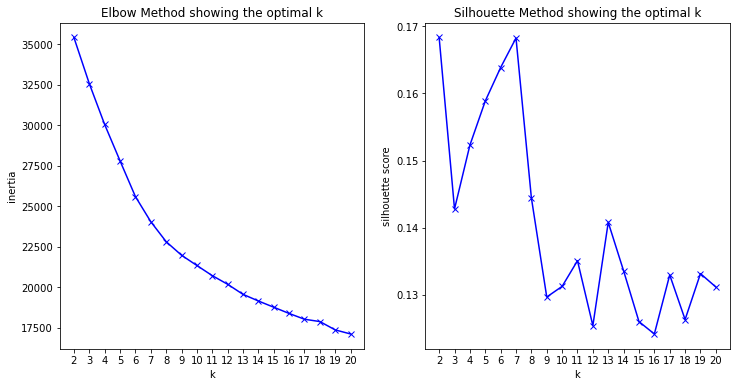

In [15]:
K = range(2, 21)

inertia = []
silhouette = []

for k in K:
    # print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)
    
    filename = "models/kmeans_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

As we can see k=7 is the best option.

In [16]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

Saving the scaler we used as 'use_scaler' and the best model as a variable 'best_model'.

In [17]:
use_scaler = load("scalers/standard.pickle")
use_scaler

StandardScaler()

In [18]:
best_model_kmeans = load("models/kmeans_7.pickle")
best_model_kmeans

KMeans(n_clusters=7, random_state=1234, verbose=1)

Saving the results of the best model as a separate column in our datadrame.

In [19]:
filepath = 'models/kmeans_7.pickle'

with open(filepath, 'rb') as file:
    kmeans = pickle.load(file)

clusters = kmeans.predict(X_scaled_df)
final_dataset_with_prediction = final_dataset.copy()
final_dataset_with_prediction['kmeans_7'] = kmeans.predict(X_scaled_df)
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,kmeans_7
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,2
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4,3
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4,2
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,4
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,3


<h2>2. Agglomerative clustering (by Guiherme)</h2>

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.describe().T)
print()
display(X_scaled_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
danceability,3862.0,0.553274,0.160590,0.099400,0.442000,0.557000,0.667000,0.979
energy,3862.0,0.576020,0.237822,0.022000,0.391250,0.588000,0.770000,0.998
key,3862.0,5.345935,3.563238,0.000000,2.000000,5.000000,9.000000,11.000
loudness,3862.0,-9.526688,4.088085,-33.424000,-12.170000,-8.984500,-6.367000,-0.734
mode,3862.0,0.712843,0.452494,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,3862.0,0.069094,0.074288,0.022600,0.032000,0.040950,0.067975,0.914
acousticness,3862.0,0.329874,0.321676,0.000001,0.031950,0.218000,0.614000,0.995
instrumentalness,3862.0,0.077450,0.209585,0.000000,0.000000,0.000079,0.007488,0.985
liveness,3862.0,0.196316,0.167393,0.018500,0.094525,0.127000,0.243750,0.991
tempo,3862.0,120.163958,29.525342,38.498000,96.491500,118.033500,139.949500,209.034


,count,mean,std,min,25%,50%,75%,max
danceability,3862.0,-1.609852e-18,1.000129,-2.826650,-0.692997,0.023203,0.708264,2.651345
energy,3862.0,4.253459e-16,1.000129,-2.329861,-0.777026,0.050381,0.815759,1.774584
key,3862.0,-1.074576e-16,1.000129,-1.500497,-0.939137,-0.097097,1.025623,1.586983
loudness,3862.0,-3.881325e-16,1.000129,-5.846358,-0.646673,0.132644,0.773002,2.151087
mode,3862.0,1.879502e-16,1.000129,-1.575569,-1.575569,0.634691,0.634691,0.634691
speechiness,3862.0,-1.381023e-16,1.000129,-0.625944,-0.499393,-0.378901,-0.015069,11.374801
acousticness,3862.0,-6.295672e-17,1.000129,-1.025614,-0.926281,-0.347830,0.883382,2.067957
instrumentalness,3862.0,1.760920e-16,1.000129,-0.369588,-0.369588,-0.369210,-0.333858,4.330788
liveness,3862.0,-2.328536e-18,1.000129,-1.062400,-0.608172,-0.414143,0.283406,4.748018
tempo,3862.0,3.376377e-16,1.000129,-2.766320,-0.801871,-0.072166,0.670207,3.010348


In [21]:
aglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#aglo.fit(X_scaled_df)
clusters = aglo.fit_predict(X_scaled_df)
clusters

array([3586, 2269, 2339, ...,    6,    2,    0])

In [22]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

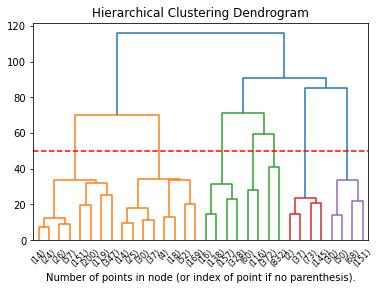

In [23]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(aglo, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=50, color='r', linestyle='--')
plt.show()

In [24]:
K = range(2, 21)
silhouette = []
i=0
for k in K:
    
    print("Training a Agglomeration model with {} neighbours! ".format(k))
    print()
    aglo = AgglomerativeClustering(n_clusters=k)
    aglo.fit_predict(X_scaled_df)
    filename = "models/aglo_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(aglo,file)
    silhouette.append(silhouette_score(X_scaled_df, aglo.fit_predict(X_scaled_df)))
    print("Silhouette score turned out to be {}".format(round(silhouette[i], 4)))
    print("------------------------------------------------------")
    i+=1

Training a Agglomeration model with 2 neighbours! 

Silhouette score turned out to be 0.1483
------------------------------------------------------
Training a Agglomeration model with 3 neighbours! 

Silhouette score turned out to be 0.1578
------------------------------------------------------
Training a Agglomeration model with 4 neighbours! 

Silhouette score turned out to be 0.1851
------------------------------------------------------
Training a Agglomeration model with 5 neighbours! 

Silhouette score turned out to be 0.1586
------------------------------------------------------
Training a Agglomeration model with 6 neighbours! 

Silhouette score turned out to be 0.1704
------------------------------------------------------
Training a Agglomeration model with 7 neighbours! 

Silhouette score turned out to be 0.1791
------------------------------------------------------
Training a Agglomeration model with 8 neighbours! 

Silhouette score turned out to be 0.1398
-------------------

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

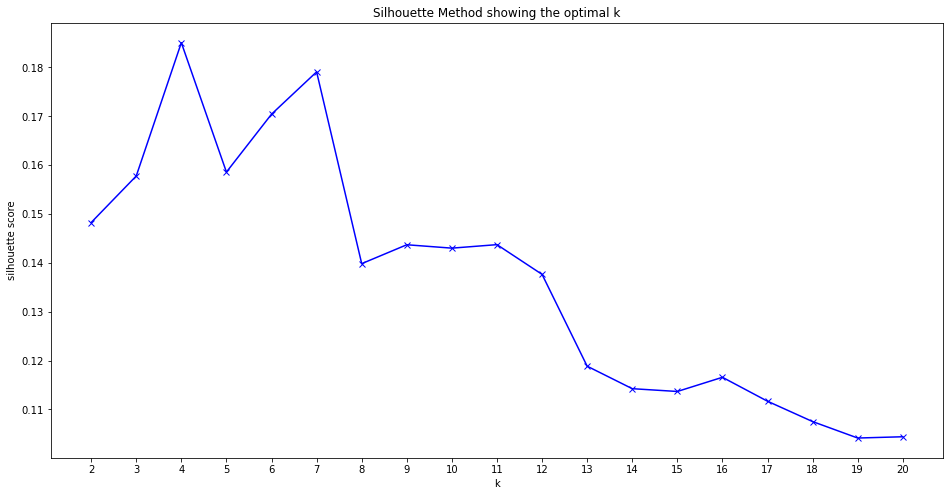

In [25]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

ax.plot(K, silhouette, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
ax.set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax.set_title('Silhouette Method showing the optimal k')

In [26]:
L=['ward', 'complete', 'average', 'single']
n_silhouette = []
i=0
for lin in L:
    
    print("Training a Agglomeration model with 7 neighbours and {} linkage!".format(lin))
    print()
    aglo = AgglomerativeClustering(n_clusters=7, linkage=lin)
    aglo.fit_predict(X_scaled_df)
    filename = "models/aglo_7_" + str(lin) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(aglo,file)
    n_silhouette.append(silhouette_score(X_scaled_df, aglo.fit_predict(X_scaled_df)))
    print("Silhouette score turned out to be {}".format(n_silhouette[i]))
    print("-----------------------------------------------------")
    i+=1

Training a Agglomeration model with 7 neighbours and ward linkage!

Silhouette score turned out to be 0.17908564954082098
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and complete linkage!

Silhouette score turned out to be 0.16281973000250474
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and average linkage!

Silhouette score turned out to be 0.3567406234009862
-----------------------------------------------------
Training a Agglomeration model with 7 neighbours and single linkage!

Silhouette score turned out to be 0.46154526799943396
-----------------------------------------------------


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

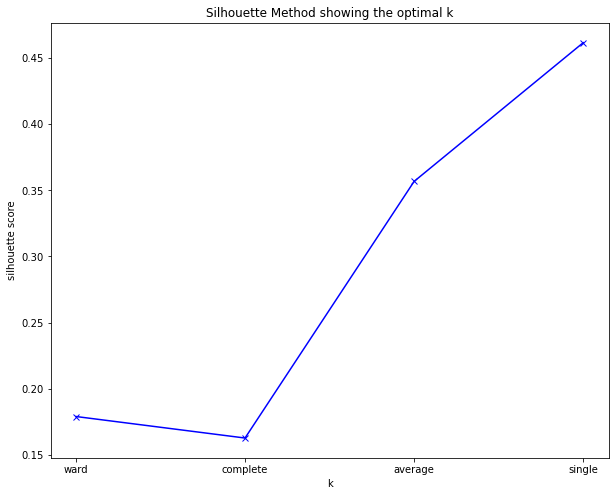

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(L, n_silhouette, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
ax.set_title('Silhouette Method showing the optimal k')

In [28]:
sin_model = load("models/aglo_7_single.pickle")
sin_aglo = sin_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['sin_aglo']=sin_aglo

In [29]:
avg_model = load("models/aglo_7_average.pickle")
avg_aglo = avg_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['avg_aglo']=avg_aglo

In [30]:
ward_model = load("models/aglo_7_ward.pickle")
ward_aglo = ward_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['ward_aglo']=ward_aglo

In [31]:
cmp_model = load("models/aglo_7_complete.pickle")
cmp_aglo = cmp_model.fit_predict(X_scaled_df)
final_dataset_with_prediction['cmp_aglo']=cmp_aglo

In [32]:
display(final_dataset_with_prediction.head())

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,kmeans_7,sin_aglo,avg_aglo,ward_aglo,cmp_aglo
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,2,0,2,0,2
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4,3,0,2,5,2
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4,2,0,2,0,2
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,4,0,2,4,0
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,3,0,2,5,2


<h2>3. Gaussian Mixtures (by Rafael)</h2>

<h3>Training method</h3>

<h4>Full covariance matrix:</h4>

In [33]:
# Testing with 1 cluster with an spherical shape per column.

gmm = GaussianMixture(n_components=11, covariance_type='full')

In [34]:
gmm.fit(X_scaled_df)

GaussianMixture(n_components=11)

<h3>Predicting the clusters</h3>

<h4>Gaussian Mixture 11 clusters:</h4>

In [35]:
ygmm_hat = gmm.predict(X_scaled_df)
ygmm_hat

array([6, 0, 6, ..., 4, 6, 0])

In [36]:
X["GMM11_cluster"] = ygmm_hat

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6


In [37]:
ss_gmm11 = silhouette_score(X_scaled_df, gmm.predict(X_scaled_df))

print(ss_gmm11)

0.07571143213266736


<h4>Gaussian Mixture 6 clusters:</h4>

In [38]:
gmm2 = GaussianMixture(n_components=6, covariance_type='full')

In [39]:
gmm2.fit(X_scaled_df)

GaussianMixture(n_components=6)

In [40]:
ygmm_hat2 = gmm2.predict(X_scaled_df)
ygmm_hat2

array([1, 0, 1, ..., 4, 1, 0])

In [41]:
X["GMM6_cluster"] = ygmm_hat2

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1


In [42]:
ss_gmm6 = silhouette_score(X_scaled_df, gmm2.predict(X_scaled_df))

print(ss_gmm6)

0.13627820874112373


<h4>Gaussian Mixture 3 clusters:</h4>

In [43]:
gmm3 = GaussianMixture(n_components=3, covariance_type='full')

In [44]:
gmm3.fit(X_scaled_df)

GaussianMixture(n_components=3)

In [45]:
ygmm_hat3 = gmm3.predict(X_scaled_df)
ygmm_hat3

array([2, 0, 2, ..., 0, 2, 0])

In [46]:
X["GMM3_cluster"] = ygmm_hat3

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2


In [47]:
ss_gmm3 = silhouette_score(X_scaled_df, gmm3.predict(X_scaled_df))

print(ss_gmm3)

0.1467323555246733


<h4>Gaussian Mixture 7 clusters:</h4>

In [48]:
gmm4 = GaussianMixture(n_components=7, covariance_type='full')

In [49]:
gmm4.fit(X_scaled_df)

GaussianMixture(n_components=7)

In [50]:
ygmm_hat4 = gmm4.predict(X_scaled_df)
ygmm_hat4

array([3, 1, 3, ..., 5, 3, 1])

In [51]:
X["GMM7_cluster"] = ygmm_hat4

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3


In [52]:
ss_gmm7 = silhouette_score(X_scaled_df, gmm4.predict(X_scaled_df))

print(ss_gmm7)

0.17175232399711649


<h4>Gaussian Mixture 8 clusters:</h4>

In [53]:
gmm5 = GaussianMixture(n_components=8, covariance_type='full')

In [54]:
gmm5.fit(X_scaled_df)

GaussianMixture(n_components=8)

In [55]:
ygmm_hat5 = gmm5.predict(X_scaled_df)
ygmm_hat5

array([7, 1, 7, ..., 6, 7, 1])

In [56]:
X["GMM8_cluster"] = ygmm_hat5

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7


In [57]:
ss_gmm8 = silhouette_score(X_scaled_df, gmm5.predict(X_scaled_df))

print(ss_gmm8)

0.1357277981518731


 <h3>Comparing silhouette scores:</h3>


In [58]:
print(f'The Silhouette score for the Gaussian Mixture with 11 clusters is: {(round(ss_gmm11,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 8 clusters is: {(round(ss_gmm8,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 7 clusters is: {(round(ss_gmm7,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 6 clusters is: {(round(ss_gmm6,4))}')
print(f'The Silhouette score for the Gaussian Mixture with 3 clusters is: {(round(ss_gmm3,4))}')
print('')
print('The optimal number of clusters is 7.')

The Silhouette score for the Gaussian Mixture with 11 clusters is: 0.0757
The Silhouette score for the Gaussian Mixture with 8 clusters is: 0.1357
The Silhouette score for the Gaussian Mixture with 7 clusters is: 0.1718
The Silhouette score for the Gaussian Mixture with 6 clusters is: 0.1363
The Silhouette score for the Gaussian Mixture with 3 clusters is: 0.1467

The optimal number of clusters is 7.


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Tied covariance matrix:</h3>

In [59]:
gmm_tied = GaussianMixture(n_components=7, covariance_type='tied')

In [60]:
gmm_tied.fit(X_scaled_df)

GaussianMixture(covariance_type='tied', n_components=7)

In [61]:
ygmm_hat_tied = gmm_tied.predict(X_scaled_df)
ygmm_hat_tied

array([0, 4, 0, ..., 4, 0, 4])

In [62]:
X["GMM7_tied_cluster"] = ygmm_hat_tied

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7,0
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1,4
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7,0
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5,1
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1,4
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5,1
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6,4
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7,0


In [63]:
ss_gmm_tied = silhouette_score(X_scaled_df, gmm_tied.predict(X_scaled_df))

print(ss_gmm_tied)

0.11869872961024774


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Diagonal covariance matrix:</h3>

<h3>Gaussian Mixture (diagonal) - 7 clusters:</h3>


In [64]:
gmm_d = GaussianMixture(n_components=7, covariance_type='diag')

In [65]:
gmm_d.fit(X_scaled_df)

GaussianMixture(covariance_type='diag', n_components=7)

In [66]:
ygmm_hat_d = gmm_d.predict(X_scaled_df)
ygmm_hat_d

array([2, 6, 2, ..., 1, 2, 6])

In [67]:
X["GMM7_diag_cluster"] = ygmm_hat_d

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7,0,2
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1,4,6
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7,0,2
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5,1,3
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1,4,6
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5,1,3
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6,4,1
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7,0,2


In [68]:
ss_gmm_d = silhouette_score(X_scaled_df, gmm_d.predict(X_scaled_df))

print(ss_gmm_d)

0.1575958044158382


<h2>Gaussian Mixtures:</h2>

<h3>Training method:</h3>

<h3>Diagonal covariance matrix:</h3>

<h3>Gaussian Mixture (spherical) - 7 clusters:</h3>

In [69]:
gmm_s = GaussianMixture(n_components=7, covariance_type='spherical')

In [70]:
gmm_s.fit(X_scaled_df)

GaussianMixture(covariance_type='spherical', n_components=7)

In [71]:
ygmm_hat_s = gmm_s.predict(X_scaled_df)
ygmm_hat_s

array([4, 3, 5, ..., 0, 1, 3])

In [72]:
X["GMM7_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7,0,2,4
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1,4,6,3
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7,0,2,5
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5,1,3,1
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1,4,6,3
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5,1,3,5
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6,4,1,0
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7,0,2,1


In [73]:
ss_gmm_s = silhouette_score(X_scaled_df, gmm_s.predict(X_scaled_df))

print(ss_gmm_s)

0.12300892023337714


In [74]:
gmm_s8 = GaussianMixture(n_components=8, covariance_type='spherical')

In [75]:
gmm_s8.fit(X_scaled_df)

GaussianMixture(covariance_type='spherical', n_components=8)

In [76]:
ygmm_hat_s8 = gmm_s8.predict(X_scaled_df)
ygmm_hat_s8

array([1, 0, 1, ..., 2, 1, 0])

In [77]:
X["GMM8_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster,GMM8_spherical_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7,0,2,4,4
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1,4,6,3,3
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7,0,2,5,5
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5,1,3,1,1
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7,3,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1,4,6,3,3
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5,1,3,5,5
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6,4,1,0,0
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7,0,2,1,1


In [78]:
ss_gmm_8 = silhouette_score(X_scaled_df, gmm_s8.predict(X_scaled_df))

print(ss_gmm_8)

0.1518733100445326


<h2>Conclusions: </h2>

Between all the models the one with the highest silhouette score is the spherical Gaussian Mixture with 7 Clusters.

In [79]:
print(f'The Silhouette score for the full Gaussian Mixture with 7 clusters is: {(round(ss_gmm7,4))}')
print(f'The Silhouette score for the tied Gaussian Mixture with 7 clusters is: {(round(ss_gmm_tied,4))}')
print(f'The Silhouette score for the diagonal Gaussian Mixture with 7 clusters is: {(round(ss_gmm_d,4))}')
print(f'The Silhouette score for the spherical Gaussian Mixture with 7 clusters is: {(round(ss_gmm_s,4))}')
print('')
print('The optimal model for the Gaussian Mixture is spherical with 7 clusters.')

The Silhouette score for the full Gaussian Mixture with 7 clusters is: 0.1718
The Silhouette score for the tied Gaussian Mixture with 7 clusters is: 0.1187
The Silhouette score for the diagonal Gaussian Mixture with 7 clusters is: 0.1576
The Silhouette score for the spherical Gaussian Mixture with 7 clusters is: 0.123

The optimal model for the Gaussian Mixture is spherical with 7 clusters.


In [80]:
X['GMM7_spherical_cluster'].value_counts()

5    901
3    866
4    818
1    516
0    302
2    261
6    198
Name: GMM7_spherical_cluster, dtype: int64

In [81]:
X["GMM7_spherical_cluster"] = ygmm_hat_s

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,cluster,GMM11_cluster,GMM6_cluster,GMM3_cluster,GMM7_cluster,GMM8_cluster,GMM7_tied_cluster,GMM7_diag_cluster,GMM7_spherical_cluster,GMM8_spherical_cluster
0,0.637,0.643,4,-6.571,1,0.0519,0.1300,0.000002,0.1420,97.008,4,1,6,1,2,3,7,0,2,4,4
1,0.247,0.299,9,-6.083,1,0.0315,0.8990,0.000000,0.1310,177.115,4,0,0,0,0,1,1,4,6,3,3
2,0.686,0.507,1,-7.097,1,0.0357,0.6260,0.000075,0.3830,168.955,4,1,6,1,2,3,7,0,2,5,5
3,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,173.930,4,2,7,3,1,2,5,1,3,1,1
4,0.733,0.436,10,-10.489,1,0.0800,0.2580,0.000573,0.1570,96.985,4,1,6,1,2,3,7,3,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,0.725,0.468,8,-15.821,1,0.0436,0.1360,0.000019,0.0721,94.566,4,0,0,0,0,1,1,4,6,3,3
3858,0.576,0.834,9,-3.089,0,0.0470,0.3450,0.000000,0.1880,78.713,4,2,7,3,1,2,5,1,3,5,5
3859,0.620,0.282,5,-10.533,0,0.0464,0.6940,0.000000,0.1190,124.609,3,0,4,4,0,5,6,4,1,0,0
3860,0.700,0.620,2,-9.360,1,0.0797,0.0175,0.000003,0.0891,173.998,4,1,6,1,2,3,7,0,2,1,1


In [82]:
final_dataset_with_prediction['GMM7'] = X["GMM7_spherical_cluster"]
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,kmeans_7,sin_aglo,avg_aglo,ward_aglo,cmp_aglo,GMM7
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,2,0,2,0,2,4
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4,3,0,2,5,2,3
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4,2,0,2,0,2,5
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,4,0,2,4,0,1
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,3,0,2,5,2,4


<h2>5. Which model to choose?</h2>

We listened to a couple of songs from our song recommender and decided to choose **[X]** clustering model.

We can check out silhouette_score for each model and choose the highest?

In [83]:
kmeans = KMeans(n_clusters=5, random_state=12345)
kmeans.fit(X_scaled_df)


clusters = kmeans.predict(X_scaled_df) #clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0     725
1    1422
2    1165
3     263
4     287
dtype: int64

In [84]:
# Kmeans k=7

silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df))


0.18850871559251248

In [85]:
# gmm_s 

silhouette_score(X_scaled_df, gmm_s.predict(X_scaled_df))


0.12300892023337714

In [86]:
# cmp_aglo

silhouette_score(X_scaled_df, cmp_model.fit_predict(X_scaled_df))

0.16281973000250474

In [87]:
final_dataset_with_prediction.columns

Index(['track_name', 'artist_name', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'kmeans_7', 'sin_aglo',
       'avg_aglo', 'ward_aglo', 'cmp_aglo', 'GMM7'],
      dtype='object')

In [88]:
final_dataset_with_prediction = final_dataset_with_prediction.drop(['sin_aglo','avg_aglo', 'ward_aglo', 'cmp_aglo', 'GMM7'], axis = 1)
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,kmeans_7
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,2
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4,3
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4,2
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,4
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,3


In [89]:
# Save the dataset
final_dataset_with_prediction.to_csv('final_dataset_with_prediction.csv')

<h2>4. Recomendation system</h2>

**Let's go through all the steps of our pipeline:**

1) User inputs a song

2) Get user's song audio features 

3) Predict user's song cluster membership (using the best clustering model)

4) Is the user's song included in the hot songs database?

 - If yes: Recommend another song from the same cluster from the hot_songs database
        
 - If no: Recommend another song from the same cluster from the not_hot_songs database

5) The user wants another reccomendation?

 - If yes: Start again from the first step
        
 - If no: End

In [90]:
hot_songs_with_audio_features = pd.read_csv('hot_songs_with_audio_features.csv')
not_hot_songs_with_audio_features = pd.read_csv('not_hot_songs_with_audio_features.csv')

In [91]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret= Client_Secret))

In [92]:
final_dataset_with_prediction.head()

,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,kmeans_7
0,anti-hero,taylor swift,0.637,0.643,4,-6.571,1,0.0519,0.130,0.000002,0.142,0.5330,97.008,hot,0V3wPSX9ygBnCm8psDIegu,spotify:track:0V3wPSX9ygBnCm8psDIegu,https://api.spotify.com/v1/tracks/0V3wPSX9ygBn...,https://api.spotify.com/v1/audio-analysis/0V3w...,200690,4,2
1,lift me up,rihanna,0.247,0.299,9,-6.083,1,0.0315,0.899,0.000000,0.131,0.1720,177.115,hot,35ovElsgyAtQwYPYnZJECg,spotify:track:35ovElsgyAtQwYPYnZJECg,https://api.spotify.com/v1/tracks/35ovElsgyAtQ...,https://api.spotify.com/v1/audio-analysis/35ov...,196520,4,3
2,bad habit,steve lacy,0.686,0.507,1,-7.097,1,0.0357,0.626,0.000075,0.383,0.6900,168.955,hot,5CM4UuQ9Gnd6K2YyKGPMoK,spotify:track:5CM4UuQ9Gnd6K2YyKGPMoK,https://api.spotify.com/v1/tracks/5CM4UuQ9Gnd6...,https://api.spotify.com/v1/audio-analysis/5CM4...,232115,4,2
3,as it was,harry styles,0.520,0.731,6,-5.338,0,0.0557,0.342,0.001010,0.311,0.6620,173.930,hot,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,4
4,lavender haze,taylor swift,0.733,0.436,10,-10.489,1,0.0800,0.258,0.000573,0.157,0.0976,96.985,hot,5jQI2r1RdgtuT8S3iG8zFC,spotify:track:5jQI2r1RdgtuT8S3iG8zFC,https://api.spotify.com/v1/tracks/5jQI2r1Rdgtu...,https://api.spotify.com/v1/audio-analysis/5jQI...,202396,4,3


In [93]:
def search_song(title, artist, ask_for_options=True):
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret= Client_Secret))
    print("Searching for song {} of artist {}".format(title,artist))
    results = sp.search(q="track:"+title+" artist:"+artist,limit=10)
    if ask_for_options == True:
        if len(results['tracks']['items']) > 1:
            count = 0
            for item in results['tracks']['items']:
                print(count,"Song: '{}', artist: '{}', album: '{}', duration: {} minutes".format(item['name'], item['artists'][0]['name'],item['album']['name'], round((item['duration_ms']/60000),2)))
                count = count + 1
            song_index = int(input("Desirable song (row number): "))
            return results['tracks']['items'][song_index]['uri'] 

        elif len(results['tracks']['items']) == 1:
            return results['tracks']['items'][0]['uri'] 
        else:
            return ''
    
    if ask_for_options == False:
        if len(results['tracks']['items']) >= 1:
            return results['tracks']['items'][0]['uri']
        else:
            return ''

Creating a function, checking if the song is hot:

In [94]:
def is_hot_song(uri):
    return (uri in final_dataset_with_prediction['uri'].unique()) and ((final_dataset_with_prediction[final_dataset_with_prediction['uri'] == uri]['type'] == 'hot')[0])

In [95]:
is_hot_song('spotify:track:0V3wPSX9ygBnCm8psDIegu')  # hot song

True

Adding everything into one function:

In [96]:
# One of the options of the song_recommender function

# def recommend_song(track_name,artist_name):

#     # User inputs a song name and artist name 
#     track_name = input('Enter a song name: ')
#     artist_name = input('Enter artist name: ')
#     inputed_song = {'track_name': [track_name], 'artist_name': [artist_name]}
#     inputed_song_df = pd.DataFrame(inputed_song)

#     # getting uri of this song
#     song_uri = search_song(track_name, artist_name, ask_for_options=True)

#     # getting audio features of this song
#     sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret= Client_Secret))
#     result = sp.audio_features(song_uri)
#     result_df = pd.DataFrame(result)

#     # Choosing features for the model
#     X = result_df[['danceability', 'energy', 'key',
#            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
#            'liveness', 'tempo', 'time_signature']]

#     # Scaling the data
#     X_scaled = use_scaler.transform(X)
#     X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

#     # Predicting a cluster
#     predicted_cluster = best_model_kmeans.predict(X_scaled_df)

#     # Putting all in one df
#     song_with_audio_features = pd.concat([inputed_song_df.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)
#     song_with_audio_features['cluster'] = predicted_cluster
#     song_with_audio_features.head()

#     # Checking if this song is from hot_songs list
#     if is_hot_song(song_with_audio_features['uri'][0]):

#         list_of_hot_songs = final_dataset_with_prediction[final_dataset_with_prediction['type'] == 'hot']
#         hot_same_cluster_songs = list_of_hot_songs[list_of_hot_songs['kmeans_7'] == predicted_cluster[0]]
#         recommended_song = hot_same_cluster_songs.sample()

#     else:

#         list_of_not_hot_songs = final_dataset_with_prediction[final_dataset_with_prediction['type'] != 'hot']
#         not_hot_same_cluster_songs = list_of_not_hot_songs[list_of_not_hot_songs['kmeans_7'] == predicted_cluster[0]]
#         recommended_song = not_hot_same_cluster_songs.sample()


#     return(recommended_song[['track_name', 'artist_name', 'uri', 'track_href', 'analysis_url']])


Testing:

In [97]:
# recommend_song(track_name,artist_name)

And we are continuing with the demo in Song_recommender.ipynb file.